In [1]:
# https://forum.effectivealtruism.org/posts/HDFxQwMwPp275J87r/net-global-welfare-may-be-negative-and-declining-1
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
AQUA_COLS = {'Carps, barbels and other cyprinids': 'Carp',
             'Salmons, trouts, smelts': 'Salmon', 'Shrimps, prawns': 'Shrimp'}
    # https://fishcount.org.uk/studydatascreens2/2015/Farmed-fishes-living-2015.xlsx
    # https://www.getguesstimate.com/models/21679
AQUA_PARAMS = pd.read_csv('data/aqua-params.csv', index_col=0)
LAND_COLS = {'Cattle': 'Cattle', 'Chickens': 'Chickens', 'Ducks': 'Ducks',
             'Goats': 'Goats', 'Swine / pigs': 'Pigs', 'Sheep': 'Sheep'}
INDEX_COLS = ['Country', 'Year']
# https://rethinkpriorities.org/publications/welfare-range-estimates
# https://docs.google.com/spreadsheets/d/1dWzh0Se0nhbPxe2Ye3o-tr3BoOBtdiCbMkpPuw2rBFE/edit#gid=1196679822
WELFARE_PARAMS = pd.read_csv('data/welfare-params.csv', index_col=0)

In [3]:
# https://www.fao.org/faostat/en/#data/QCL
df = pd.read_csv('data/FAOSTAT_data_en_5-29-2024.csv')
df['Value'] = df.apply(lambda x: x['Value']*1000 if x['Unit']
                       == '1000 An' else x['Value'], axis=1)
population = df.pivot_table(
    index=['Area', 'Year'], columns='Item', values='Value', aggfunc='sum')[LAND_COLS.keys()]
population.rename(columns=LAND_COLS, inplace=True)
population.columns = population.columns.values
population.fillna(0, inplace=True)
population.index.names = INDEX_COLS
population.head()

Cattle   Chickens  Ducks      Goats  Pigs       Sheep
Country     Year                                                          
Afghanistan 1961  2900000.0  4700000.0    0.0  4200000.0   0.0  18000000.0
            1962  3200000.0  4900000.0    0.0  4087270.0   0.0  18150000.0
            1963  3300000.0  5000000.0    0.0  3800000.0   0.0  18500000.0
            1964  3350000.0  5300000.0    0.0  3500000.0   0.0  19000000.0
            1965  3400000.0  5500000.0    0.0  3200000.0   0.0  19600000.0

In [4]:
def standardize_country_names(country):
    mapping = {
        'Bolivia (Plurinat.State)': 'Bolivia (Plurinational State of)',
        'Congo, Dem. Rep. of the': 'Democratic Republic of the Congo',
        'Iran (Islamic Rep. of)': 'Iran (Islamic Republic of)',
        "Korea, Dem. People's Rep": "Democratic People's Republic of Korea",
        'Korea, Republic of': 'Republic of Korea',
        "Lao People's Dem. Rep.": "Lao People's Democratic Republic",
        'Micronesia (Fed. States)': 'Micronesia (Federated States of)',
        'Moldova, Republic of': 'Republic of Moldova',
        'Taiwan Province of China': 'China, Taiwan Province of',
        'Tanzania, United Rep. of': 'United Republic of Tanzania',
        'Un. Sov. Soc. Rep.': 'USSR',
        'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
        'Venezuela (Boliv Rep of)': 'Venezuela (Bolivarian Republic of)',
        'Yugoslavia SFR': 'Yugoslav SFR'
    }

    return mapping.get(country, country)

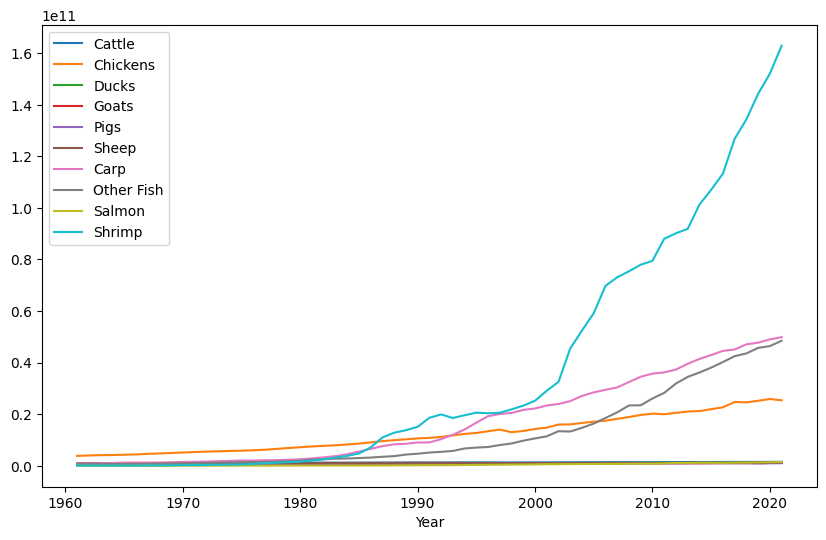

In [5]:
# https://www.fao.org/fishery/statistics-query/en/aquaculture/aquaculture_quantity
df = pd.read_csv(
    'data/aquaculture_quantity.csv').drop('Unit Name', axis=1)
df.drop(list(df.filter(regex='Flag')), axis=1, inplace=True)

weight = df.melt(id_vars=['Country Name En', 'ISSCAAP group Name En'], var_name='Year').pivot_table(
    index=['Country Name En', 'Year'], columns='ISSCAAP group Name En', values='value', aggfunc='sum')
weight.fillna(0, inplace=True)
weight.index = weight.index.set_levels(
    weight.index.levels[1].astype(int), level=1)
weight.index.names = INDEX_COLS
weight.index = weight.index.set_levels(
    weight.index.levels[0].map(standardize_country_names), level='Country')

other_cols = weight.columns.to_list()
_ = [other_cols.remove(x) for x in AQUA_COLS.keys()]
weight['Other Fish'] = weight[other_cols].sum(axis=1)
weight.drop(other_cols, axis=1, inplace=True)
weight.rename(columns=AQUA_COLS, inplace=True)
weight.columns = weight.columns.values

population[AQUA_PARAMS.columns] = weight.apply(
    lambda x: x*(1e6/AQUA_PARAMS.loc['weight'])*AQUA_PARAMS.loc['lifespan'], axis=1)
population.dropna(inplace=True)
population.to_csv('data/population.csv')

fig, ax = plt.subplots()
_ = population.groupby('Year').sum().plot(ax=ax)

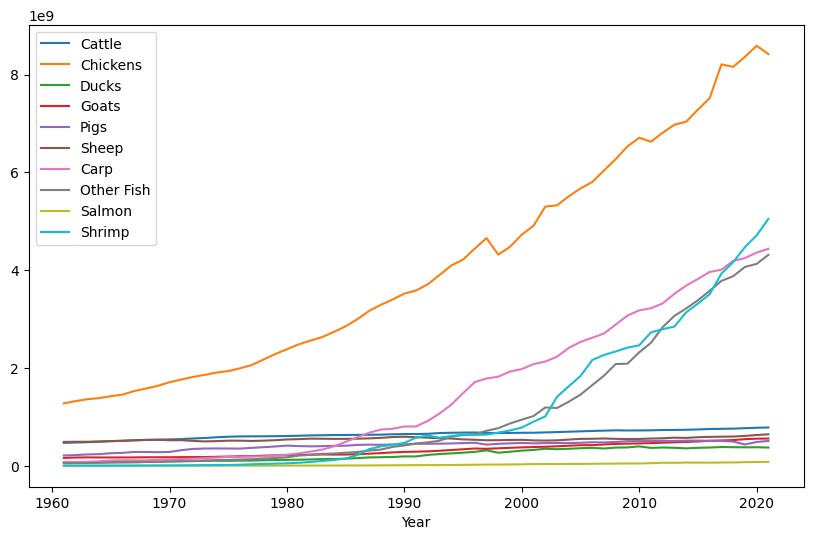

In [6]:
capacity = population.apply(lambda x: x*WELFARE_PARAMS.loc['range'], axis=1)

fig, ax = plt.subplots()
_ = capacity.groupby('Year').sum().plot(ax=ax)

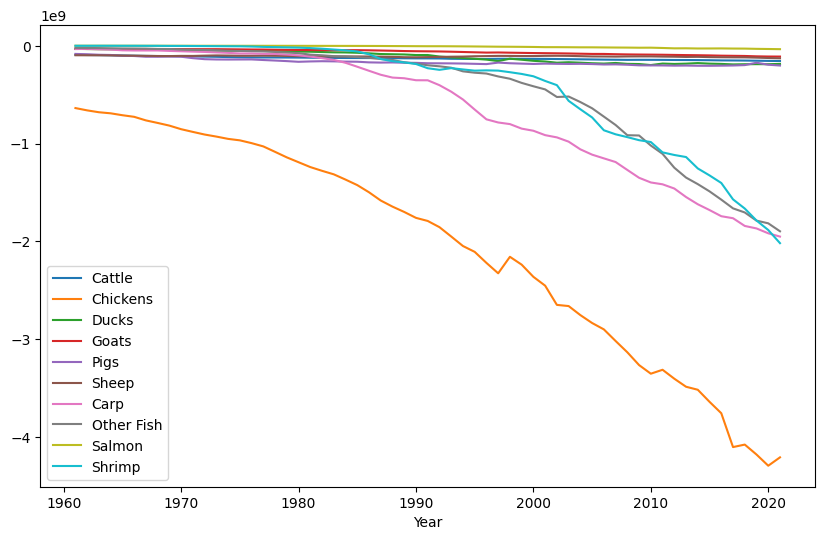

In [7]:
welfare = capacity.apply(lambda x: x*WELFARE_PARAMS.loc['value'], axis=1)

fig, ax = plt.subplots()
_ = welfare.groupby('Year').sum().plot(ax=ax)